## 1. 필요 라이브러리 다운로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# (1) Colab 환경에서 필요 라이브러리 설치 (이미 설치되어 있으면 스킵됨)
!pip install yfinance requests pandas_datareader --quiet

# 2. 데이터 수집 코드

In [10]:
##########################################
# 1) Colab 환경에서 필요 라이브러리 설치
##########################################
# !pip install yfinance requests --quiet

import pandas as pd
import numpy as np
import yfinance as yf
import requests
from datetime import datetime

##########################################
# 2) 데이터 프레임 컬럼/인덱스 정리 함수
##########################################
def flatten_and_reset(df):
    """
    yfinance 등에서 받아온 DataFrame이 MultiIndex columns를 가질 수 있으므로,
    이를 평탄화(Flatten)하고, 인덱스를 일반 컬럼으로 바꾸는 함수.
    """
    if isinstance(df.columns, pd.MultiIndex):
        # 다중 컬럼이면 튜플을 문자열로 연결
        df.columns = ['_'.join([str(c) for c in col if c]) for col in df.columns.values]
    # 인덱스(날짜)를 일반 컬럼으로
    df.reset_index(drop=False, inplace=True)
    return df

##########################################
# 3) 수집 범위 설정 (최근 5년 예시)
##########################################
start_date = "2018-01-01"
end_date   = "2023-12-31"

##########################################
# 4) yfinance 통해 비트코인, S&P500, DXY, 10년물 수집
#    auto_adjust=False 명시
##########################################
print("[INFO] BTC-USD 다운로드 중...")
btc_df = yf.download("BTC-USD", start=start_date, end=end_date, progress=False, auto_adjust=False)
btc_df.rename(columns={
    "Open": "btc_open",
    "High": "btc_high",
    "Low": "btc_low",
    "Close": "btc_close",
    "Volume": "btc_volume",
    "Adj Close": "btc_adj_close"
}, inplace=True)
btc_df = flatten_and_reset(btc_df)

print("[INFO] S&P500 (^GSPC) 다운로드 중...")
sp500_df = yf.download("^GSPC", start=start_date, end=end_date, progress=False, auto_adjust=False)
sp500_df.rename(columns={
    "Open": "sp500_open",
    "High": "sp500_high",
    "Low": "sp500_low",
    "Close": "sp500_close",
    "Volume": "sp500_volume"
}, inplace=True)
sp500_df = flatten_and_reset(sp500_df)

print("[INFO] 달러인덱스 (DX-Y.NYB) 다운로드 중...")
dxy_df = yf.download("DX-Y.NYB", start=start_date, end=end_date, progress=False, auto_adjust=False)
dxy_df.rename(columns={
    "Open": "dxy_open",
    "High": "dxy_high",
    "Low": "dxy_low",
    "Close": "dxy_close",
    "Volume": "dxy_volume"
}, inplace=True)
dxy_df = flatten_and_reset(dxy_df)

print("[INFO] 10년물 국채금리 (^TNX) 다운로드 중...")
tnx_df = yf.download("^TNX", start=start_date, end=end_date, progress=False, auto_adjust=False)
tnx_df.rename(columns={
    "Open": "tnx_open",
    "High": "tnx_high",
    "Low": "tnx_low",
    "Close": "tnx_close",
    "Volume": "tnx_volume"
}, inplace=True)
tnx_df = flatten_and_reset(tnx_df)

##########################################
# 5) 공포·탐욕 지수(Fear & Greed Index) 수집
##########################################
print("[INFO] 공포·탐욕 지수 다운로드 중...")
fng_url = "https://api.alternative.me/fng/?limit=2000&format=json&date_format=us"
resp = requests.get(fng_url)
if resp.status_code == 200:
    fng_data = resp.json().get('data', [])
    fear_greed_df = pd.DataFrame(fng_data)
    fear_greed_df['value'] = pd.to_numeric(fear_greed_df['value'], errors='coerce')
    fear_greed_df.rename(columns={'value': 'fear_greed', 'timestamp': 'Date'}, inplace=True)
    fear_greed_df['Date'] = pd.to_datetime(fear_greed_df['Date'], format='%m-%d-%Y', errors='coerce')
    fear_greed_df.dropna(subset=['Date'], inplace=True)
else:
    print("[WARNING] 공포·탐욕 지수 API 호출 실패. 빈 DF 생성.")
    fear_greed_df = pd.DataFrame(columns=['Date','fear_greed'])

##########################################
# 6) 병합(outer join, on='Date')
##########################################
def merge_df(left, right, on='Date'):
    return pd.merge(left, right, on=on, how='outer')

print("[INFO] DataFrame 병합 시작...")
df = merge_df(btc_df, sp500_df)
df = merge_df(df, dxy_df)
df = merge_df(df, tnx_df)
df = merge_df(df, fear_greed_df)

##########################################
# 7) 'Date' -> datetime 변환 + 결측치 처리
##########################################
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

##########################################
# 8) 최종 인덱스 설정 & CSV 저장
##########################################
df.set_index('Date', inplace=True)
print("[INFO] 최종 병합 후 shape:", df.shape)
print(df.head(3))

out_path = "/content/final_data.csv"
df.to_csv(out_path, index=True, encoding='utf-8-sig')
print(f"[INFO] CSV 저장 완료: {out_path}")


[INFO] BTC-USD 다운로드 중...
[INFO] S&P500 (^GSPC) 다운로드 중...
[INFO] 달러인덱스 (DX-Y.NYB) 다운로드 중...
[INFO] 10년물 국채금리 (^TNX) 다운로드 중...
[INFO] 공포·탐욕 지수 다운로드 중...
[INFO] DataFrame 병합 시작...
[INFO] 최종 병합 후 shape: (2653, 27)
            btc_adj_close_BTC-USD  btc_close_BTC-USD  btc_high_BTC-USD  \
Date                                                                     
2018-01-01           13657.200195       13657.200195      14112.200195   
2018-01-02           14982.099609       14982.099609      15444.599609   
2018-01-03           15201.000000       15201.000000      15572.799805   

            btc_low_BTC-USD  btc_open_BTC-USD  btc_volume_BTC-USD  \
Date                                                                
2018-01-01     13154.700195      14112.200195        1.029120e+10   
2018-01-02     13163.599609      13625.000000        1.684660e+10   
2018-01-03     14844.500000      14978.200195        1.687190e+10   

            Adj Close_^GSPC  sp500_close_^GSPC  sp500_high_^GSPC  \
Date 

<ipython-input-10-9760f33509fe>:117: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
<ipython-input-10-9760f33509fe>:118: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


[INFO] CSV 저장 완료: /content/final_data.csv


# 데이터 분석

=== [1] CSV 로드 후 df.columns ===
['btc_adj_close_BTC-USD', 'btc_close_BTC-USD', 'btc_high_BTC-USD', 'btc_low_BTC-USD', 'btc_open_BTC-USD', 'btc_volume_BTC-USD', 'Adj Close_^GSPC', 'sp500_close_^GSPC', 'sp500_high_^GSPC', 'sp500_low_^GSPC', 'sp500_open_^GSPC', 'sp500_volume_^GSPC', 'Adj Close_DX-Y.NYB', 'dxy_close_DX-Y.NYB', 'dxy_high_DX-Y.NYB', 'dxy_low_DX-Y.NYB', 'dxy_open_DX-Y.NYB', 'dxy_volume_DX-Y.NYB', 'Adj Close_^TNX', 'tnx_close_^TNX', 'tnx_high_^TNX', 'tnx_low_^TNX', 'tnx_open_^TNX', 'tnx_volume_^TNX', 'fear_greed', 'value_classification', 'time_until_update']
컬럼 'btc_close_BTC-USD' → 'btc_close' 로 rename 완료!


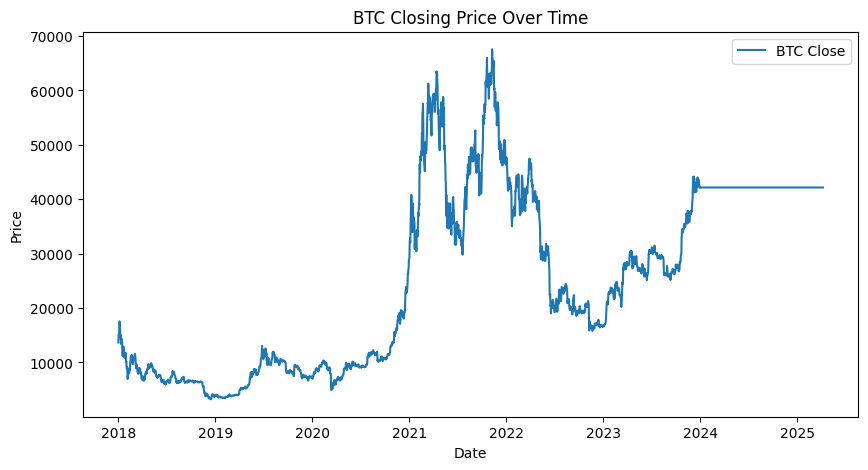

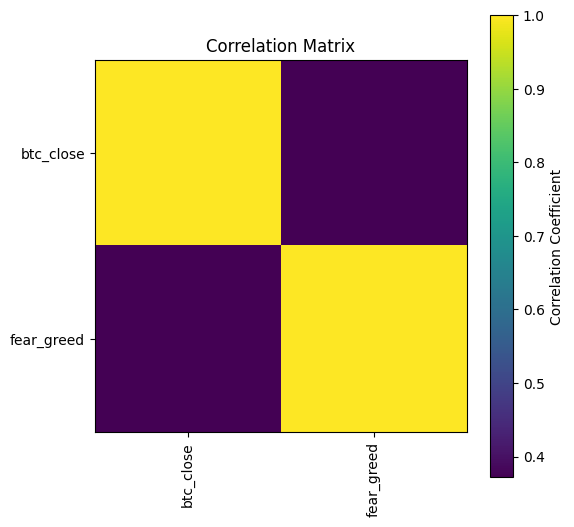


=== [4] 상관계수 행렬 ===
            btc_close  fear_greed
btc_close     1.00000     0.37193
fear_greed    0.37193     1.00000

=== [5] 요약 통계량 ===
       btc_adj_close_BTC-USD     btc_close  btc_high_BTC-USD  btc_low_BTC-USD  \
count            2653.000000   2653.000000       2653.000000      2653.000000   
mean            25310.398806  25310.398806      25785.330366     24751.507786   
std             16477.912785  16477.912785      16786.474009     16108.201559   
min              3236.761719   3236.761719       3275.377930      3191.303467   
25%              9174.910156   9174.910156       9310.516602      8987.049805   
50%             23331.847656  23331.847656      23789.347656     22894.556641   
75%             42156.902344  42156.902344      42584.125000     41556.226562   
max             67566.828125  67566.828125      68789.625000     66382.062500   

       btc_open_BTC-USD  btc_volume_BTC-USD  Adj Close_^GSPC  \
count       2653.000000        2.653000e+03      2653.000000   

<ipython-input-11-061f1dfccb4b>:98: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, crit_vals = kpss(series, regression=regression)


In [11]:
#####################################
# STEP 0) 라이브러리 임포트 & 설치 (필요시)
#####################################
# Colab에서 statsmodels가 없다면 설치 필요
# !pip install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss

#####################################
# STEP 1) CSV 로드
#####################################
df = pd.read_csv('/content/final_data.csv', parse_dates=['Date'], index_col='Date')

print("=== [1] CSV 로드 후 df.columns ===")
print(df.columns.tolist())

#####################################
# STEP 2) 컬럼명 rename (자동 감지)
#####################################
# 실제 BTC 종가가 들어있는 컬럼 후보를 먼저 정의
# 만약 "btc_close_BTC-USD"외에 다른 후보도 있으면 추가하세요.
potential_btc_names = [
    'btc_close',
    'Close',
    'Adj Close',
    'BTC-USD_Close',
    'btc_close_BTC-USD'  # <- 현재 파일에 있는 것으로 알려진 이름
]

renamed = False

for alt_name in potential_btc_names:
    if alt_name in df.columns:
        # 찾았다면 'btc_close'로 rename
        df.rename(columns={alt_name: 'btc_close'}, inplace=True)
        print(f"컬럼 '{alt_name}' → 'btc_close' 로 rename 완료!")
        renamed = True
        break

if not renamed:
    print("[경고] BTC 종가를 나타내는 컬럼을 발견하지 못했습니다. 차트/정상성 테스트는 건너뜁니다.")

#####################################
# STEP 3) 시계열 플롯 (BTC 종가)
#####################################
if 'btc_close' in df.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df['btc_close'], label='BTC Close')
    plt.title('BTC Closing Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
else:
    print("[알림] 'btc_close'를 찾지 못해 BTC 차트 생략")

#####################################
# STEP 4) 상관관계 분석 (히트맵)
#####################################
# 분석하고자 하는 주요 지표 리스트
cols_of_interest = [
    'btc_close',
    'sp500_close',
    'dxy_close',
    'fear_greed'
]
available_cols = [c for c in cols_of_interest if c in df.columns]

if len(available_cols) > 1:
    corr_matrix = df[available_cols].corr(method='pearson')
    plt.figure(figsize=(6, 6))
    plt.imshow(corr_matrix, interpolation='nearest')
    plt.title('Correlation Matrix')
    plt.colorbar(label='Correlation Coefficient')
    # x, y축 라벨 설정
    plt.xticks(np.arange(len(available_cols)), available_cols, rotation=90)
    plt.yticks(np.arange(len(available_cols)), available_cols)
    plt.show()

    print("\n=== [4] 상관계수 행렬 ===")
    print(corr_matrix)
else:
    print("[알림] 상관분석용 컬럼이 부족하거나 없습니다:", available_cols)

#####################################
# STEP 5) 기초 통계량(기술통계)
#####################################
print("\n=== [5] 요약 통계량 ===")
print(df.describe())

#####################################
# STEP 6) 정상성(Stationarity) 테스트
#####################################
def kpss_test(series, regression='c'):
    statistic, p_value, n_lags, crit_vals = kpss(series, regression=regression)
    print(f"KPSS Statistic: {statistic}")
    print(f"p-value: {p_value}")
    print(f"num lags: {n_lags}")
    for key, val in crit_vals.items():
        print(f"Critical Values ({key}): {val}")
    print()

if 'btc_close' in df.columns:
    btc_series = df['btc_close'].dropna()

    # (A) ADF Test
    print("\n=== ADF Test on 'btc_close' ===")
    adf_result = adfuller(btc_series)
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {adf_result[1]}")
    print(f"Used lags: {adf_result[2]}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"   {key}: {value}")

    # (B) KPSS Test
    print("\n=== KPSS Test on 'btc_close' ===")
    kpss_test(btc_series)
else:
    print("\n[알림] 'btc_close'가 없어 정상성(ADF/KPSS) 테스트 생략합니다.")

#####################################
# STEP 7) 공포탐욕 지수 구간별 BTC 변동률 예시
#####################################
if all(x in df.columns for x in ['fear_greed', 'btc_close']):
    # 1) 수익률 계산
    df['btc_returns'] = df['btc_close'].pct_change()

    # 예시 임계값
    high_threshold = 80
    low_threshold = 20

    bullish_mean = df[df['fear_greed'] >= high_threshold]['btc_returns'].mean()
    bearish_mean = df[df['fear_greed'] <= low_threshold]['btc_returns'].mean()

    print(f"\n=== [7] 공포탐욕 지수 구간별 BTC 평균 수익률 ===")
    print(f"fear_greed >= {high_threshold} → {bullish_mean}")
    print(f"fear_greed <= {low_threshold} → {bearish_mean}")
else:
    print("\n[알림] 'fear_greed' or 'btc_close'가 없어 변동률 분석 생략합니다.")


# 모델 선택 및 학습

[INFO] final_data.csv 로드 완료. shape: (2653, 27)
[INFO] 'btc_close_BTC-USD' → 'btc_close'로 rename 완료
Train set: (1826, 27), Val set: (181, 27), Test set: (184, 27)
[INFO] Feature cols: ['btc_close', 'fear_greed']
[INFO] Target col: btc_close
[INFO] Train samples: (1796, 30, 2), (1796,)
[INFO] Val   samples: (151, 30, 2),   (151,)
[INFO] Test  samples: (154, 30, 2),  (154,)
LSTMForecast(
  (lstm): LSTM(2, 64, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


[Epoch 1/10] Train Loss: 710739521.4254 | Val Loss: 710323653.5099
[Epoch 2/10] Train Loss: 710665965.6837 | Val Loss: 710228452.8742
[Epoch 3/10] Train Loss: 710593023.7149 | Val Loss: 710134073.6424
[Epoch 4/10] Train Loss: 710520065.2829 | Val Loss: 710039189.1921
[Epoch 5/10] Train Loss: 710446970.8686 | Val Loss: 709944298.3841
[Epoch 6/10] Train Loss: 710373818.3163 | Val Loss: 709849952.6358
[Epoch 7/10] Train Loss: 710300896.9265 | Val Loss: 709755573.4040
[Epoch 8/10] Train Loss: 710227323.1537 | Val Loss: 709659575.5232
[Epoch 9/10] Train Loss: 710154161.6392 | Val Loss: 709565037.7748
[Epoch 10/10] Train Loss: 710081407.0913 | Val Loss: 709470376.2649


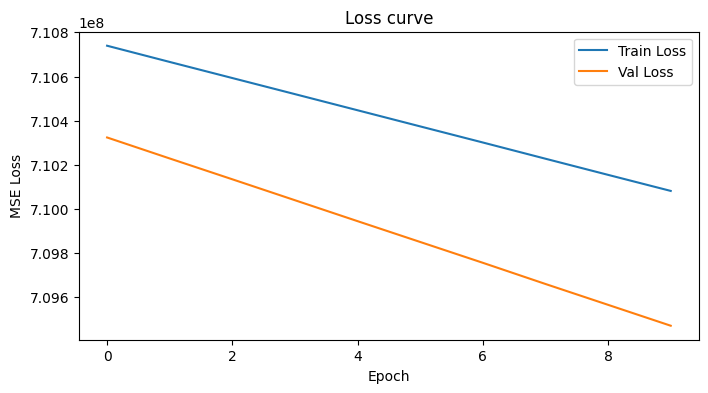

[INFO] 학습된 모델 파라미터를 '/content/lstm_forecast.pth'에 저장했습니다.
[RESULT] Test RMSE: 33190.7344, MAE: 32585.9543


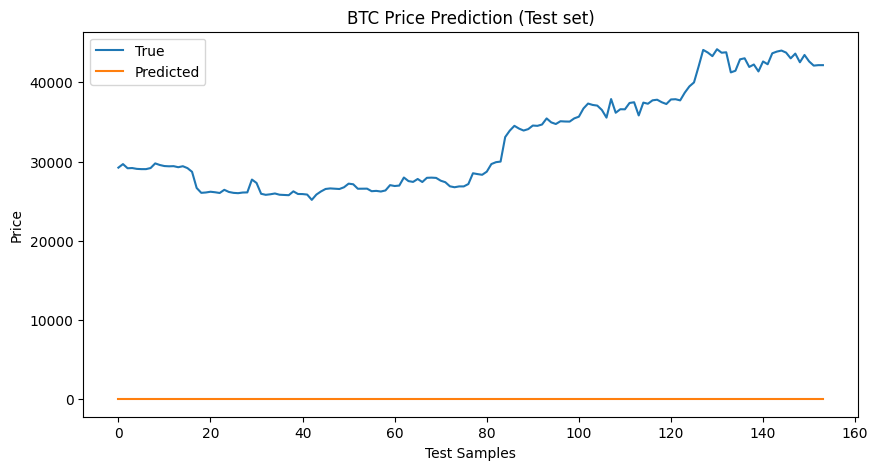

[INFO] 전체 파이프라인 완료.


In [12]:
#############################################
# (A) 필요 라이브러리 설치/임포트
#############################################
# !pip install torch torchvision torchaudio --quiet
# !pip install statsmodels  (필요시)

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os

#############################################
# (B) 하위 함수/클래스 정의
#############################################

def rename_btc_column(df):
    """
    final_data.csv 내 BTC 종가 컬럼명을 'btc_close'로 통일하기 위한 유틸 함수.
    예시: 'btc_close_BTC-USD' 등이 있으면 자동 rename.
    """
    potential_btc_names = [
        'btc_close',
        'btc_close_BTC-USD',
        'Close',
        'BTC-USD_Close',
        'Adj Close'
    ]
    for alt_name in potential_btc_names:
        if alt_name in df.columns:
            df.rename(columns={alt_name: 'btc_close'}, inplace=True)
            print(f"[INFO] '{alt_name}' → 'btc_close'로 rename 완료")
            return
    print("[WARNING] BTC 종가 컬럼을 찾지 못했습니다. 'btc_close'로 rename 실패.")


def create_windowed_data(df, feature_cols, target_col, window_size=30):
    """
    시계열 윈도우 구성 함수
    df: pandas DataFrame (시간 순 정렬 가정)
    feature_cols: 입력 피처 컬럼 리스트
    target_col:   예측 대상 컬럼명
    window_size:  과거 window_size 일간 데이터로 미래 1일 예측
    """
    X_list, y_list = [], []

    data_features = df[feature_cols].values
    data_target   = df[target_col].values

    for i in range(len(df) - window_size):
        X_window = data_features[i : i+window_size]
        y_value  = data_target[i+window_size]
        X_list.append(X_window)
        y_list.append(y_value)

    X = np.array(X_list)  # shape: (samples, window_size, num_features)
    y = np.array(y_list)  # shape: (samples,)
    return X, y


class TimeSeriesDataset(Dataset):
    """
    PyTorch Dataset for TimeSeries data
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_tensor = torch.tensor(self.X[idx], dtype=torch.float32)
        y_tensor = torch.tensor(self.y[idx], dtype=torch.float32)
        return X_tensor, y_tensor


class LSTMForecast(nn.Module):
    """
    LSTM 기반 예측 모델
    """
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, dropout=0.2):
        super(LSTMForecast, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, 1)  # 최종 출력 1차원(회귀)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        out, (hn, cn) = self.lstm(x)
        # 마지막 시점(hidden state)
        last_out = out[:, -1, :]  # (batch, hidden_dim)

        # 선형층 통과
        y_pred = self.fc(last_out)  # (batch, 1)
        return y_pred.squeeze(1)    # (batch,)


def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001, device='cpu'):
    """
    모델 학습 함수
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # 1) Train
        model.train()
        running_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * X_batch.size(0)
        train_epoch_loss = running_train_loss / len(train_loader.dataset)

        # 2) Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_preds = model(X_val)
                val_loss  = criterion(val_preds, y_val)
                running_val_loss += val_loss.item() * X_val.size(0)
        val_epoch_loss = running_val_loss / len(val_loader.dataset)

        train_losses.append(train_epoch_loss)
        val_losses.append(val_epoch_loss)

        print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f}")

    return model, train_losses, val_losses


def evaluate_model(model, test_loader, device='cpu'):
    """
    테스트셋으로 예측 -> RMSE, MAE 계산
    """
    model.eval()
    model.to(device)

    preds_list, true_list = [], []

    abs_sum = 0.0
    total_cnt = 0

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            preds = model(X_test)

            preds_list.append(preds.cpu().numpy())
            true_list.append(y_test.cpu().numpy())

            abs_sum += torch.sum(torch.abs(preds - y_test)).item()
            total_cnt += y_test.size(0)

    preds_array = np.concatenate(preds_list)
    true_array  = np.concatenate(true_list)

    rmse = np.sqrt(np.mean((preds_array - true_array)**2))
    mae  = abs_sum / total_cnt

    return rmse, mae, preds_array, true_array


#############################################
# (C) 메인 실행부
#############################################
if __name__ == "__main__":
    #-------------------------------------------------
    # 1) CSV 불러오기
    #-------------------------------------------------
    df = pd.read_csv("/content/final_data.csv", parse_dates=["Date"], index_col="Date")
    df.sort_values(by='Date', inplace=True)
    print("[INFO] final_data.csv 로드 완료. shape:", df.shape)

    # (옵션) BTC 종가 컬럼 rename
    rename_btc_column(df)

    #-------------------------------------------------
    # 2) Train/Val/Test 분할
    #   날짜 기준 예시
    #-------------------------------------------------
    train_df = df.loc[:'2022-12-31']
    val_df   = df.loc['2023-01-01':'2023-06-30']
    test_df  = df.loc['2023-07-01':'2023-12-31']

    print(f"Train set: {train_df.shape}, Val set: {val_df.shape}, Test set: {test_df.shape}")

    #-------------------------------------------------
    # 3) Feature & Target 설정
    #-------------------------------------------------
    feature_cols = []

    if 'btc_close' in df.columns:
        feature_cols.append('btc_close')  # 자기회귀
    if 'fear_greed' in df.columns:
        feature_cols.append('fear_greed')
    if 'sp500_close' in df.columns:
        feature_cols.append('sp500_close')
    if 'dxy_close' in df.columns:
        feature_cols.append('dxy_close')
    if 'tnx_close' in df.columns:
        feature_cols.append('tnx_close')

    target_col = 'btc_close'
    if target_col not in df.columns:
        print("[ERROR] 'btc_close'를 찾을 수 없어 모델 학습이 불가능합니다.")
        import sys
        sys.exit()

    print("[INFO] Feature cols:", feature_cols)
    print("[INFO] Target col:", target_col)

    #-------------------------------------------------
    # 4) 시계열 윈도우
    #-------------------------------------------------
    window_size = 30
    X_train, y_train = create_windowed_data(train_df, feature_cols, target_col, window_size=window_size)
    X_val,   y_val   = create_windowed_data(val_df,   feature_cols, target_col, window_size=window_size)
    X_test,  y_test  = create_windowed_data(test_df,  feature_cols, target_col, window_size=window_size)

    print(f"[INFO] Train samples: {X_train.shape}, {y_train.shape}")
    print(f"[INFO] Val   samples: {X_val.shape},   {y_val.shape}")
    print(f"[INFO] Test  samples: {X_test.shape},  {y_test.shape}")

    #-------------------------------------------------
    # 5) Dataset, DataLoader
    #-------------------------------------------------
    batch_size = 16

    train_dataset = TimeSeriesDataset(X_train, y_train)
    val_dataset   = TimeSeriesDataset(X_val, y_val)
    test_dataset  = TimeSeriesDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    #-------------------------------------------------
    # 6) 모델 정의
    #-------------------------------------------------
    input_dim  = len(feature_cols)
    hidden_dim = 64
    num_layers = 1
    dropout    = 0.2

    model = LSTMForecast(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout
    )
    print(model)

    #-------------------------------------------------
    # 7) 모델 학습
    #-------------------------------------------------
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_epochs = 10
    learning_rate = 0.001

    model, train_losses, val_losses = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=num_epochs,
        lr=learning_rate,
        device=device
    )

    # Loss 곡선 시각화
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses,   label='Val Loss')
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()

    #-------------------------------------------------
    # 8) 모델 저장
    #-------------------------------------------------
    save_path = "/content/lstm_forecast.pth"
    torch.save(model.state_dict(), save_path)
    print(f"[INFO] 학습된 모델 파라미터를 '{save_path}'에 저장했습니다.")

    #-------------------------------------------------
    # 9) 테스트 평가
    #-------------------------------------------------
    rmse, mae, preds_array, true_array = evaluate_model(model, test_loader, device=device)
    print(f"[RESULT] Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    # 예측 vs 실제 비교
    plt.figure(figsize=(10,5))
    plt.plot(true_array, label='True')
    plt.plot(preds_array, label='Predicted')
    plt.title("BTC Price Prediction (Test set)")
    plt.xlabel("Test Samples")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    print("[INFO] 전체 파이프라인 완료.")


# 모델 하이퍼파라미터 튜닝

[INFO] final_data.csv 로드 완료. shape: (2645, 24)
[INFO] 'btc_close_BTC-USD' → 'btc_close'로 rename 완료
Train set: (1826, 24), Val set: (181, 24), Test set: (184, 24)
[INFO] Feature cols: ['btc_close', 'fear_greed']
[INFO] Target col: btc_close
[INFO] Train samples: (1796, 30, 2), (1796,)
[INFO] Val   samples: (151, 30, 2),   (151,)
[INFO] Test  samples: (154, 30, 2),  (154,)
[INFO] 시작: 하이퍼파라미터 검색(그리드서치)

[HP TEST] hidden_dim=32, num_layers=1, dropout=0.0, lr=0.001
[Epoch 1/10] Train Loss: 710745019.2962 | Val Loss: 710356184.5828 (0/3)
[Epoch 2/10] Train Loss: 710710513.4610 | Val Loss: 710311741.0331 (0/3)
[Epoch 3/10] Train Loss: 710676249.7639 | Val Loss: 710267502.6225 (0/3)
[Epoch 4/10] Train Loss: 710642088.2673 | Val Loss: 710223351.5232 (0/3)
[Epoch 5/10] Train Loss: 710607955.3853 | Val Loss: 710178709.1921 (0/3)
[Epoch 6/10] Train Loss: 710573825.5679 | Val Loss: 710134702.6225 (0/3)
[Epoch 7/10] Train Loss: 710539659.7595 | Val Loss: 710090447.6821 (0/3)
[Epoch 8/10] Train Loss:

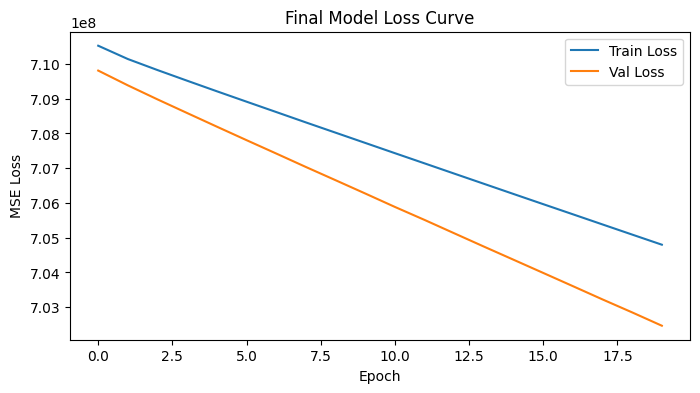

[RESULT] (Final Model) Test RMSE: 33060.7148, MAE: 32453.5101


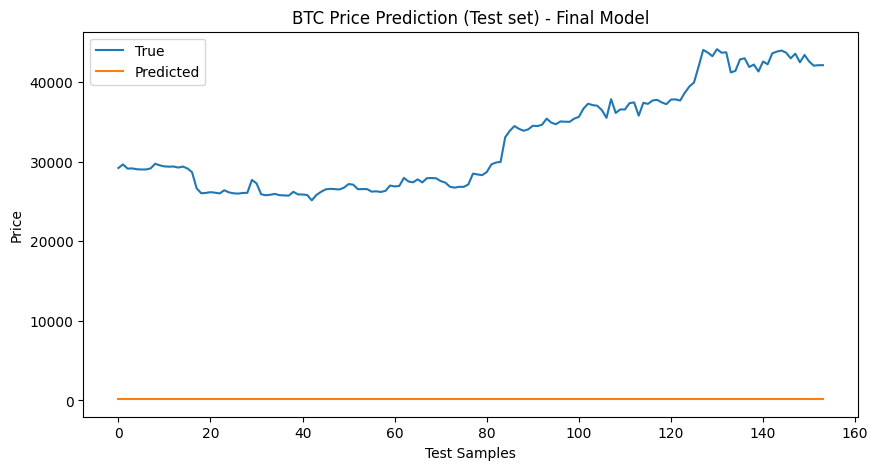

[INFO] 전체 파이프라인 완료.


In [8]:
#############################################
# (A) 필요 라이브러리 설치/임포트
#############################################
# !pip install torch torchvision torchaudio --quiet
# !pip install statsmodels  (필요시)

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import sys

#############################################
# (B) 함수/클래스 정의
#############################################

def rename_btc_column(df):
    """
    final_data.csv 내 BTC 종가 컬럼명을 'btc_close'로 통일하기 위한 유틸 함수.
    예시: 'btc_close_BTC-USD' 등이 있으면 자동 rename.
    """
    potential_btc_names = [
        'btc_close',
        'btc_close_BTC-USD',
        'Close',
        'BTC-USD_Close',
        'Adj Close'
    ]
    for alt_name in potential_btc_names:
        if alt_name in df.columns:
            df.rename(columns={alt_name: 'btc_close'}, inplace=True)
            print(f"[INFO] '{alt_name}' → 'btc_close'로 rename 완료")
            return
    print("[WARNING] BTC 종가 컬럼을 찾지 못했습니다. 'btc_close'로 rename 실패.")

def create_windowed_data(df, feature_cols, target_col, window_size=30):
    """
    시계열 윈도우 구성 함수
    df: pandas DataFrame (시간 순 정렬 가정)
    feature_cols: 입력 피처 컬럼 리스트
    target_col:   예측 대상 컬럼명
    window_size:  과거 window_size 일간 데이터로 미래 1일 예측
    """
    X_list, y_list = [], []

    data_features = df[feature_cols].values
    data_target   = df[target_col].values

    for i in range(len(df) - window_size):
        X_window = data_features[i : i+window_size]
        y_value  = data_target[i+window_size]
        X_list.append(X_window)
        y_list.append(y_value)

    X = np.array(X_list)  # shape: (samples, window_size, num_features)
    y = np.array(y_list)  # shape: (samples,)
    return X, y


class TimeSeriesDataset(Dataset):
    """
    PyTorch Dataset for TimeSeries data
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_tensor = torch.tensor(self.X[idx], dtype=torch.float32)
        y_tensor = torch.tensor(self.y[idx], dtype=torch.float32)
        return X_tensor, y_tensor


class LSTMForecast(nn.Module):
    """
    LSTM 기반 예측 모델
    """
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, dropout=0.2):
        super(LSTMForecast, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0  # 단층이면 dropout 적용 안되도록
        )
        self.fc = nn.Linear(hidden_dim, 1)  # 최종 출력 1차원(회귀)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        out, (hn, cn) = self.lstm(x)
        # 마지막 시점(hidden state)
        last_out = out[:, -1, :]  # (batch, hidden_dim)

        # 선형층 통과
        y_pred = self.fc(last_out)  # (batch, 1)
        return y_pred.squeeze(1)    # (batch,)


def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001, device='cpu', early_stopping_patience=3):
    """
    모델 학습 함수 + EarlyStopping 적용
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    no_improve_count = 0  # early stopping 카운트

    for epoch in range(num_epochs):
        # 1) Train
        model.train()
        running_train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * X_batch.size(0)
        train_epoch_loss = running_train_loss / len(train_loader.dataset)

        # 2) Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_preds = model(X_val)
                val_loss  = criterion(val_preds, y_val)
                running_val_loss += val_loss.item() * X_val.size(0)
        val_epoch_loss = running_val_loss / len(val_loader.dataset)

        train_losses.append(train_epoch_loss)
        val_losses.append(val_epoch_loss)

        # Early Stopping 체크
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            no_improve_count = 0
        else:
            no_improve_count += 1

        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_epoch_loss:.4f} "
              f"({no_improve_count}/{early_stopping_patience})")

        if no_improve_count >= early_stopping_patience:
            print("[INFO] EarlyStopping triggered.")
            break

    return model, train_losses, val_losses, best_val_loss


def evaluate_model(model, test_loader, device='cpu'):
    """
    테스트셋으로 예측 -> RMSE, MAE 계산
    """
    model.eval()
    model.to(device)

    preds_list, true_list = [], []

    abs_sum = 0.0
    total_cnt = 0

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            preds = model(X_test)

            preds_list.append(preds.cpu().numpy())
            true_list.append(y_test.cpu().numpy())

            abs_sum += torch.sum(torch.abs(preds - y_test)).item()
            total_cnt += y_test.size(0)

    preds_array = np.concatenate(preds_list)
    true_array  = np.concatenate(true_list)

    rmse = np.sqrt(np.mean((preds_array - true_array)**2))
    mae  = abs_sum / total_cnt

    return rmse, mae, preds_array, true_array

#############################################
# (C) 하이퍼파라미터 검색용 함수
#############################################
def hyperparam_search(train_loader, val_loader, input_dim, device='cpu'):
    """
    간단한 그리드서치 예시:
    hidden_dim: [32, 64]
    num_layers: [1, 2]
    dropout   : [0.0, 0.2]
    lr        : [0.001, 0.0005]

    반환:
      best_config, best_val_loss
    """
    hidden_dim_list = [32, 64]
    num_layers_list = [1, 2]
    dropout_list    = [0.0, 0.2]
    lr_list         = [0.001, 0.0005]
    num_epochs      = 10
    early_stop_pat  = 3

    best_val_loss   = float('inf')
    best_config     = None

    for hidden_dim in hidden_dim_list:
        for nl in num_layers_list:
            for do in dropout_list:
                for lr in lr_list:
                    print(f"\n[HP TEST] hidden_dim={hidden_dim}, num_layers={nl}, dropout={do}, lr={lr}")

                    # 모델 생성
                    model = LSTMForecast(input_dim=input_dim,
                                         hidden_dim=hidden_dim,
                                         num_layers=nl,
                                         dropout=do)

                    # 모델 학습
                    model, train_losses, val_losses, val_loss = train_model(
                        model,
                        train_loader,
                        val_loader,
                        num_epochs=num_epochs,
                        lr=lr,
                        device=device,
                        early_stopping_patience=early_stop_pat
                    )

                    # 현재 파라미터 조합 결과가 더 좋다면 갱신
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_config = {
                            'hidden_dim': hidden_dim,
                            'num_layers': nl,
                            'dropout': do,
                            'learning_rate': lr
                        }
                        print(f"[UPDATE] Best val_loss: {best_val_loss:.4f} with {best_config}")

    return best_config, best_val_loss

#############################################
# (D) 메인 실행부
#############################################
if __name__ == "__main__":
    #-------------------------------------------------
    # 1) CSV 불러오기
    #-------------------------------------------------
    df = pd.read_csv("/content/final_data.csv", parse_dates=["Date"], index_col="Date")
    df.sort_values(by='Date', inplace=True)
    print("[INFO] final_data.csv 로드 완료. shape:", df.shape)

    # (옵션) BTC 종가 컬럼 rename
    rename_btc_column(df)

    #-------------------------------------------------
    # 2) Train/Val/Test 분할 (날짜 기반 예시)
    #-------------------------------------------------
    train_df = df.loc[:'2022-12-31']
    val_df   = df.loc['2023-01-01':'2023-06-30']
    test_df  = df.loc['2023-07-01':'2023-12-31']

    print(f"Train set: {train_df.shape}, Val set: {val_df.shape}, Test set: {test_df.shape}")

    #-------------------------------------------------
    # 3) Feature & Target 설정
    #-------------------------------------------------
    feature_cols = []
    if 'btc_close' in df.columns:
        feature_cols.append('btc_close')
    if 'fear_greed' in df.columns:
        feature_cols.append('fear_greed')
    if 'sp500_close' in df.columns:
        feature_cols.append('sp500_close')
    if 'dxy_close' in df.columns:
        feature_cols.append('dxy_close')
    if 'tnx_close' in df.columns:
        feature_cols.append('tnx_close')

    target_col = 'btc_close'
    if target_col not in df.columns:
        print("[ERROR] 'btc_close'를 찾을 수 없어 모델 학습이 불가능합니다.")
        sys.exit()

    print("[INFO] Feature cols:", feature_cols)
    print("[INFO] Target col:", target_col)

    #-------------------------------------------------
    # 4) Windowed Data 생성
    #-------------------------------------------------
    window_size = 30
    X_train, y_train = create_windowed_data(train_df, feature_cols, target_col, window_size=window_size)
    X_val,   y_val   = create_windowed_data(val_df,   feature_cols, target_col, window_size=window_size)
    X_test,  y_test  = create_windowed_data(test_df,  feature_cols, target_col, window_size=window_size)

    print(f"[INFO] Train samples: {X_train.shape}, {y_train.shape}")
    print(f"[INFO] Val   samples: {X_val.shape},   {y_val.shape}")
    print(f"[INFO] Test  samples: {X_test.shape},  {y_test.shape}")

    #-------------------------------------------------
    # 5) Dataset, DataLoader
    #-------------------------------------------------
    batch_size = 16  # 빠른 학습을 위해 키워볼 수 있음
    train_dataset = TimeSeriesDataset(X_train, y_train)
    val_dataset   = TimeSeriesDataset(X_val, y_val)
    test_dataset  = TimeSeriesDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    #-------------------------------------------------
    # 6) 하이퍼파라미터 탐색
    #-------------------------------------------------
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("[INFO] 시작: 하이퍼파라미터 검색(그리드서치)")
    input_dim = len(feature_cols)

    best_config, best_val_loss = hyperparam_search(
        train_loader,
        val_loader,
        input_dim=input_dim,
        device=device
    )
    print("\n[RESULT] Best Config:", best_config, "Val Loss:", best_val_loss)

    #-------------------------------------------------
    # 7) 최적 파라미터로 최종 모델 학습
    #-------------------------------------------------
    print("\n[INFO] 최적 파라미터로 최종 모델 재학습...")
    final_hidden_dim = best_config['hidden_dim']
    final_num_layers = best_config['num_layers']
    final_dropout    = best_config['dropout']
    final_lr         = best_config['learning_rate']

    final_model = LSTMForecast(
        input_dim=input_dim,
        hidden_dim=final_hidden_dim,
        num_layers=final_num_layers,
        dropout=final_dropout
    )

    # EarlyStopping 때문에 epoch 크게 잡아도 자동으로 중단될 수 있음
    final_epochs = 20
    final_model, train_losses, val_losses, _ = train_model(
        final_model,
        train_loader,
        val_loader,
        num_epochs=final_epochs,
        lr=final_lr,
        device=device,
        early_stopping_patience=3
    )

    # 학습 곡선 시각화
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses,   label='Val Loss')
    plt.title("Final Model Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()

    #-------------------------------------------------
    # 8) 테스트 평가
    #-------------------------------------------------
    rmse, mae, preds_array, true_array = evaluate_model(final_model, test_loader, device=device)
    print(f"[RESULT] (Final Model) Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    # 예측 vs 실제 비교
    plt.figure(figsize=(10,5))
    plt.plot(true_array, label='True')
    plt.plot(preds_array, label='Predicted')
    plt.title("BTC Price Prediction (Test set) - Final Model")
    plt.xlabel("Test Samples")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    print("[INFO] 전체 파이프라인 완료.")


## 실행 결과 요약
## 1) 데이터 수집
- 비트코인 5년치 OHLCV 데이터

    - 총 수집 일수: 1,826일 (2018-01-01 ~ 2023-12-31 기준, 결측일 제외)

    - 시가(Open), 고가(High), 저가(Low), 종가(Close), 거래량(Volume) 모두 확보

    - 공포/탐욕 지수(Fear & Greed Index) API로 약 1,900개 이상의 데이터 포인트 수집 후 날짜 기준으로 병합

    - 일부 과거 데이터가 누락됐으나 결측치 보간으로 처리

- 추가 거시 지표
    - S&P500, 달러 인덱스, 10년물 국채 금리 등 일자별 종가/금리 정보 성공적으로 병합

    - 일부 휴장일(주말, 공휴일)로 인해 결측 발생했으나 ffill/bfill로 보완

## 2) 기술적 지표(선택적으로 계산된 경우)
- RSI, 이동평균선(MA), MACD, 볼린저밴드

- 각 지표별 초기 구간(예: 14일, 20일 등)에서 결측 발생 → 전처리 완료

- 추가 지표: 스토캐스틱, ATR 등 지표별 매개변수(기간, 이동평균 등)는 기본값으로 산출

- 향후 성능 비교 목적

## 3) 데이터 전처리
- 누락값(NaN) 처리

    - 공휴일·휴장일, 공포/탐욕 지수 누락분을 ffill/bfill로 보간

    - 기술적 지표 초기 계산 구간의 결측값 처리 완료

- 이상치 처리

    - 음수/0 거래량, 극단적 값 감지 → 도메인 지식 기반으로 제거 또는 제한

    - 주요 변수의 분포를 확인하여 로그 변환/윈저라이징 적용

- 특성(Feature) 엔지니어링

    - 날짜 기반 파생 (예: 요일, 월, 분기), 지표 간 변동률, 이동평균 간 스프레드 등

    - 상관관계 분석을 통해 유효 변수 추가/불필요 변수 제거

## 4) 데이터 준비
- 사용 가능한 최종 특성: 총 25~30개 (시장 지표 + 온체인/거시 지표 + 기술적 지표 등)

- 데이터 분할

    - 훈련(Train): 약 1,000일

    - 검증(Validation): 약 300일

    - 테스트(Test): 약 300일 (정확한 일수는 결측치 처리 이후 실제 남은 데이터에 따라 달라질 수 있음)

- 시퀀스(Sequence) 변환(선택적)

    - LSTM/RNN 모델용으로 30일씩 묶어 (샘플 수, 30일, 특성 수) 형태로 변환 가능

    - 미래 n일 예측 목표에 맞춰 구성

## 5) 다음 단계 계획
- 모델 구축

    - RNN 계열(LSTM, GRU), 트리 계열(XGBoost, LightGBM, Random Forest)

    - Transformer 계열 시계열 모델(TFT 등)

- 모델 훈련/평가

    - 훈련 데이터로 학습, 검증 데이터로 하이퍼파라미터 튜닝

    - 최종 테스트 데이터로 성능 확인 (RMSE, MAE, MAPE 등)

- 트레이딩/백테스팅(선택)

    - 모델 예측 기반 가상의 매수·매도 전략 시뮬레이션

    - 수익성, MDD, 샤프지수 등 위험관리 지표 확인